In [1]:
%matplotlib inline
# %matplotlib widget

from functools import partial
from pathlib import Path

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map

from plothelper import *

Matplotlib Version: 3.7.1


In [2]:
def milliMolarToNumberDensity(c: float) -> float:
    """Convert mM to #nm^-3

    Args:
        c (float): Input concentration

    Returns:
        float: Output number density in #nm^-3 units
    """
    return c * 6.022e-4


In [3]:
def computeForce(
    cp: float,
    phi: float,
    a: float,
    alpha: float,
    A: float,
    B: float,
    d: float,
    N: int,
    verbose: bool = False,
) -> float:
    """Compute the product of kc0 of membrane polymer brush system

    Args:
        cp (float): Protein concentration in mM
        phi (float): Ionic concentration in mM
        a (float): Monomer/Kuhn length in nm
        alpha (float): Degree of ionization
        A (float): Second virial coefficient
        B (float): Third virial coefficient
        N (float): Number of monomers in chain

    Returns:
        float: _description_
    """
    if N * a < d:
        raise RuntimeError(
            f"Protein thickness (d={d}) is greater than stretched polymer (Na={N*a})"
        )

    cp = milliMolarToNumberDensity(cp)
    phi = milliMolarToNumberDensity(phi)

    if cp == 0:
        F_elastic = 0
        F_virial = 0
        F_ion = 0

    else:
        s0 = N / (d * cp)

        if verbose:
            print(f"N = {N}, len = {N*a} nm, d = {d} nm, s0 = {s0} nm^2")

        F_elastic = 1.5 / (
            cp * s0 * a * a
        )  # (in units of kBT) elastic energy of the chain

        F_virial = (A * cp * cp + B * cp * cp * cp) * s0

        if phi == 0:
            F_ion = 0
        else:
            acop = alpha * cp / phi
            sopacop2 = np.sqrt(1 + acop * acop)
            F_ion = (-(sopacop2 - 1) * phi - alpha * cp * np.log(sopacop2 - acop)) * s0

    if verbose:
        print(f"elastic {F_elastic}, virial {F_virial},  ion {F_ion}")
        print(f"{F_elastic + F_ion + F_virial} nm^-1")
    return F_elastic + F_ion + F_virial


In [4]:
kappa = 20  # KT units
tension = 0.01  # mN/m; or pN/nm

cps = np.arange(1, 300, 1)  # mM
As = np.linspace(-10, 10, 100)

Ss = 1/(600 / (20 * milliMolarToNumberDensity(cps)))

KC0 = np.zeros(
    (
        len(As),
        len(cps),
    )
)

Radius = np.zeros(
    (
        len(As),
        len(cps),
    )
)

Force = np.zeros(
    (
        len(As),
        len(cps),
    )
)

for i, cp in enumerate(cps):
    for j, A in enumerate(As):
        KC0[j, i] = computeForce(
            cp=cp, A=A, phi=150, a=1.0, alpha=0.1, B=0, d=20, N=600
        )

        c0 = KC0[j, i] / kappa
        Radius[j, i] = 1 / np.sqrt(c0 * c0 + 2 * tension / (kappa * 4.114))
        Force[j, i] = (
            2
            * np.pi
            * kappa
            * 4.114
            * (np.sqrt(c0 * c0 + 2 * tension / (kappa * 4.114)) - c0)
        )

cp, A = np.meshgrid(Ss, As)

In [5]:
import matplotlib.ticker as ticker

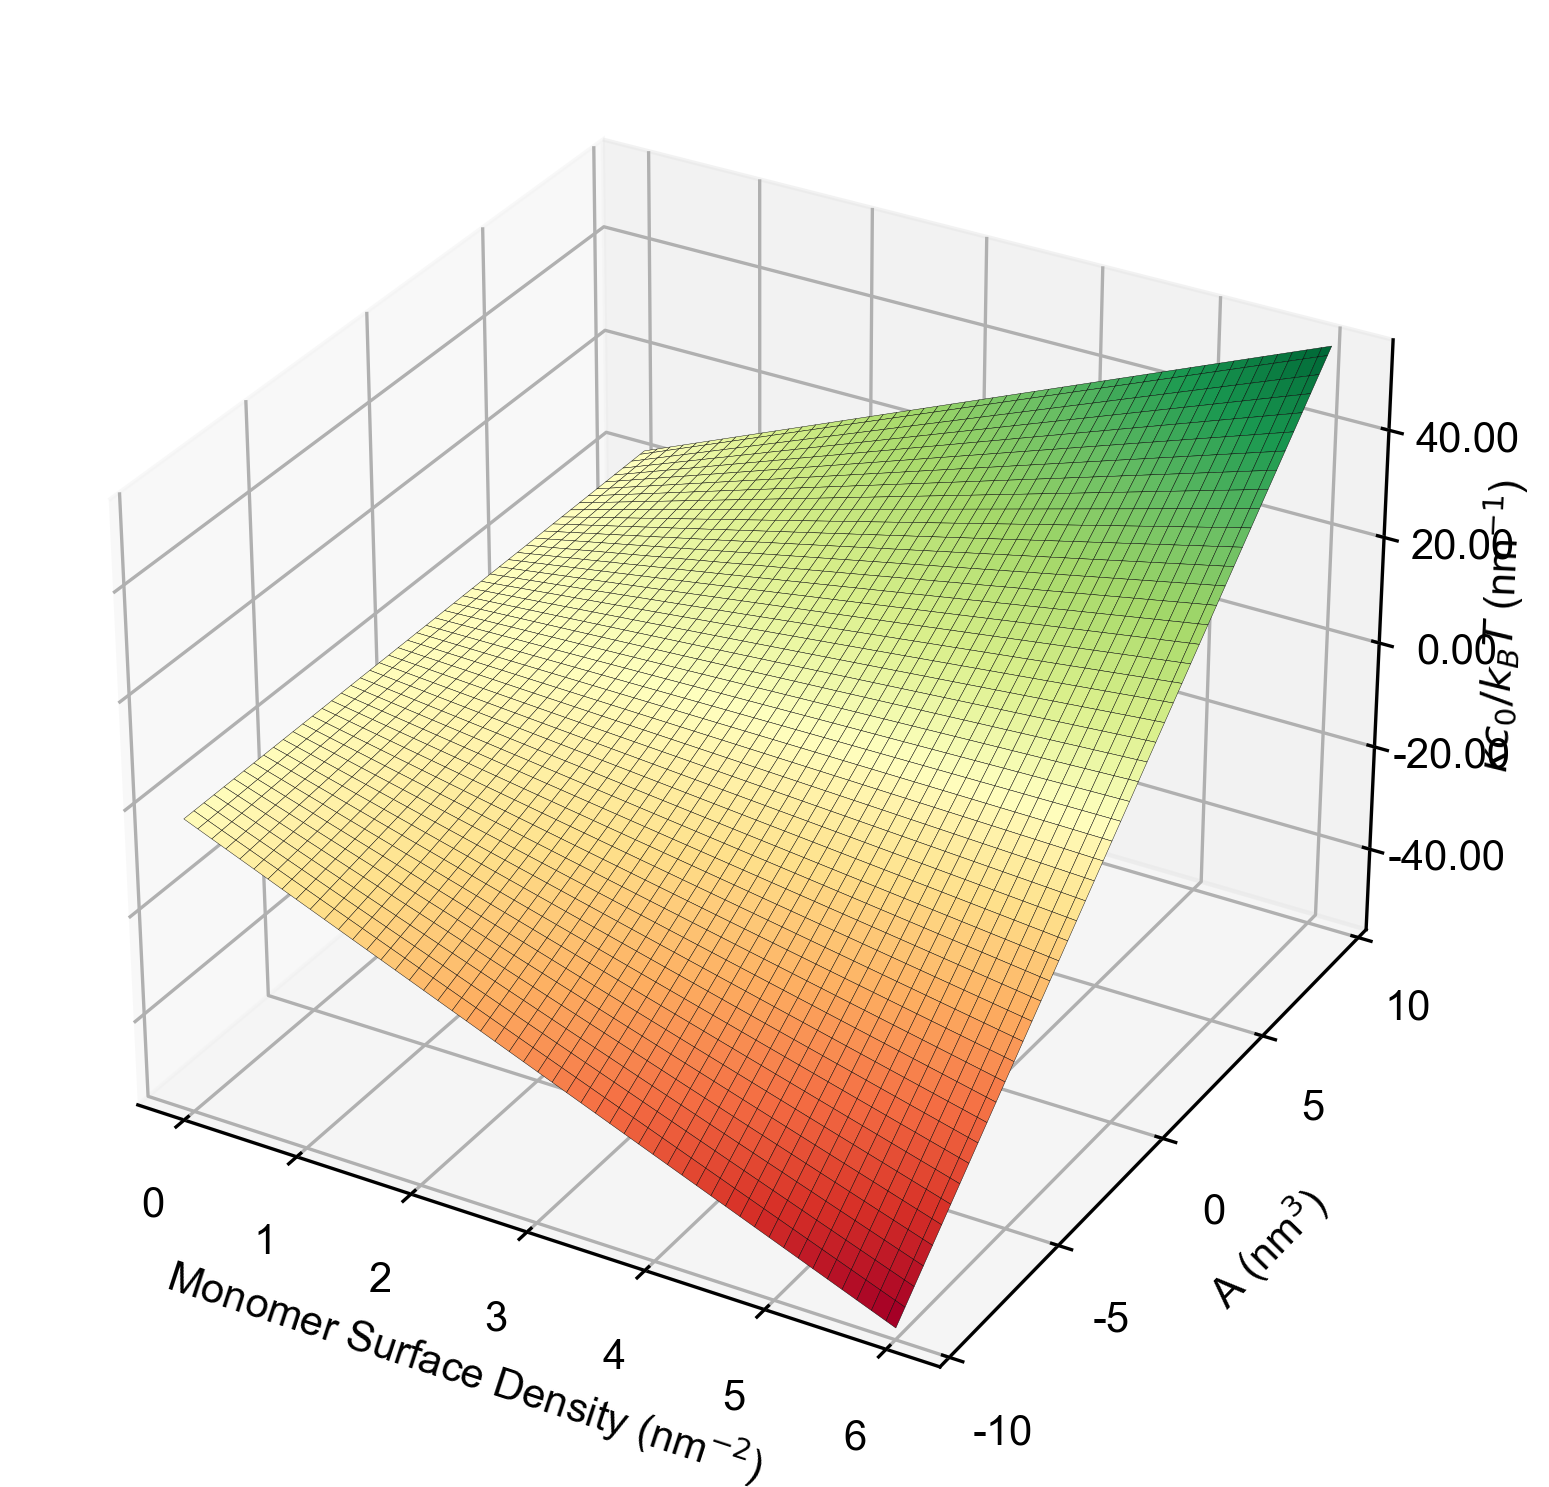

In [6]:
plot3D = True
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)


if plot3D:
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={"projection": "3d"})
else:
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# ax.set_box_aspect(aspect = (1,1,1))

if plot3D:
    ax.plot_surface(
        cp, A, KC0, cmap=cm.RdYlGn, linewidth=0.1, antialiased=True, edgecolor="k"
    )

    # surf = ax.scatter(
    #     cp[KC0>0], A[KC0>0], KC0[KC0>0], cmap=cm.RdYlGn, linewidth=0.1, antialiased=True, edgecolor="k"
    # )

    # surf = ax.scatter(
    #     cp[KC0<0], A[KC0<0], KC0[KC0<0], cmap=cm.RdYlGn, linewidth=0.1, antialiased=True, edgecolor="k"
    # )
else:
    surf = ax.pcolormesh(cp, A, KC0, cmap=cm.RdYlGn, shading="gouraud", rasterized=True)

# ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*1e3))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax.set_xlabel(r"Monomer Surface Density (nm$^{-2}$)")

ax.set_ylim((As.min(), As.max()))
ax.set_ylabel(r"A (nm$^3$)")
ax.yaxis.set_major_locator(LinearLocator(numticks=5))
ax.yaxis.set_major_formatter("{x:.0f}")

if plot3D:
    # ax.set_zlim(-5,5)
    ax.set_zlabel(r"$\kappa c_0/k_BT$ (nm$^{-1}$)")
    ax.zaxis.set_major_formatter("{x:.2f}")
    ax.zaxis.labelpad = -3
else:
    cbar = fig.colorbar(
        surf,
        ax=ax,
    )

    cbar.ax.get_yaxis().labelpad = 10
    cbar.ax.set_ylabel(r"$\kappa c_0/k_BT$ (nm$^{-1}$)", rotation=270)

fig.tight_layout()

figName = f"phase_map"

fig.savefig(curr_fig_path / f"{figName}.png", format="png")
fig.savefig(curr_fig_path / f"{figName}.pdf", format="pdf")

if show_figs:
    plt.show()
fig.clear()
plt.close(fig)


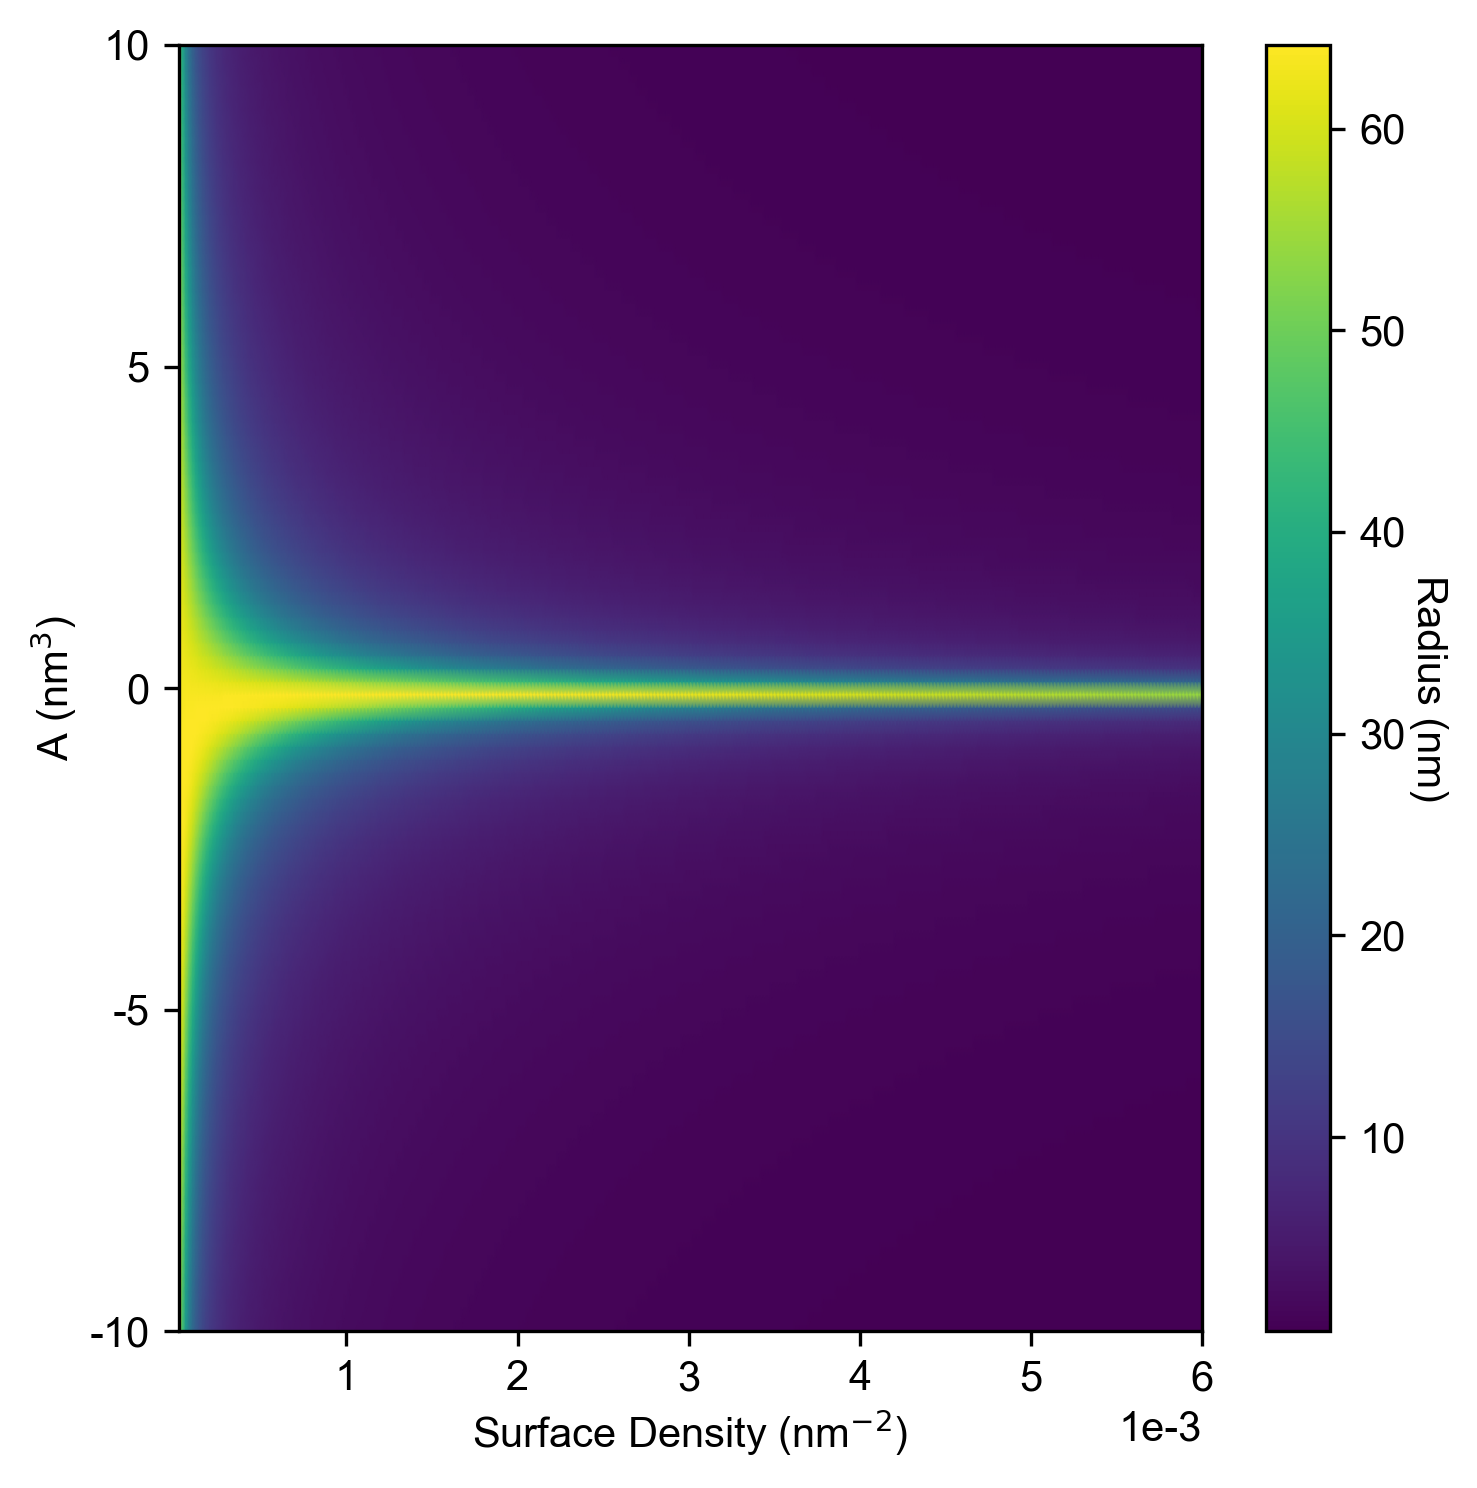

In [7]:
### PLOT THE TUBE RADIUS
plot3D = False
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

figName = f"phase_map_radius"

if plot3D:
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={"projection": "3d"})
else:
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))


if plot3D:
    surf = ax.plot_surface(
        cp,
        A,
        Radius,
        cmap=cm.viridis,
        rstride=1,
        cstride=1,
        linewidth=0.1,
        antialiased=True,
        edgecolor="k",
    )
    # Set non-default view
    ax.view_init(elev=40, azim=40, roll=10)
else:
    surf = ax.pcolormesh(cp, A, Radius, cmap=cm.viridis, shading="gouraud", rasterized=True)

# surf = ax.contour3D(cp, A, Z, 100, cmap=cm.RdYlGn)

plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax.set_xlabel(r"Surface Density (nm$^{-2}$)")

ax.set_ylim((As.min(), As.max()))
ax.set_ylabel(r"A (nm$^3$)")
ax.yaxis.set_major_locator(LinearLocator(numticks=5))
ax.yaxis.set_major_formatter("{x:.0f}")

if plot3D:
    # ax.set_zlim(-5,5)
    ax.set_zlabel(r"R (nm)")
    ax.zaxis.set_major_formatter("{x:.0f}")
    ax.zaxis.labelpad = 0
else:
    cbar = fig.colorbar(
        surf,
        ax=ax,
    )
    cbar.ax.get_yaxis().labelpad = 10
    cbar.ax.set_ylabel("Radius (nm)", rotation=270)

fig.tight_layout()


fig.savefig(curr_fig_path / f"{figName}.png", format="png")
fig.savefig(curr_fig_path / f"{figName}.pdf", format="pdf")

if show_figs:
    plt.show()
fig.clear()
plt.close(fig)


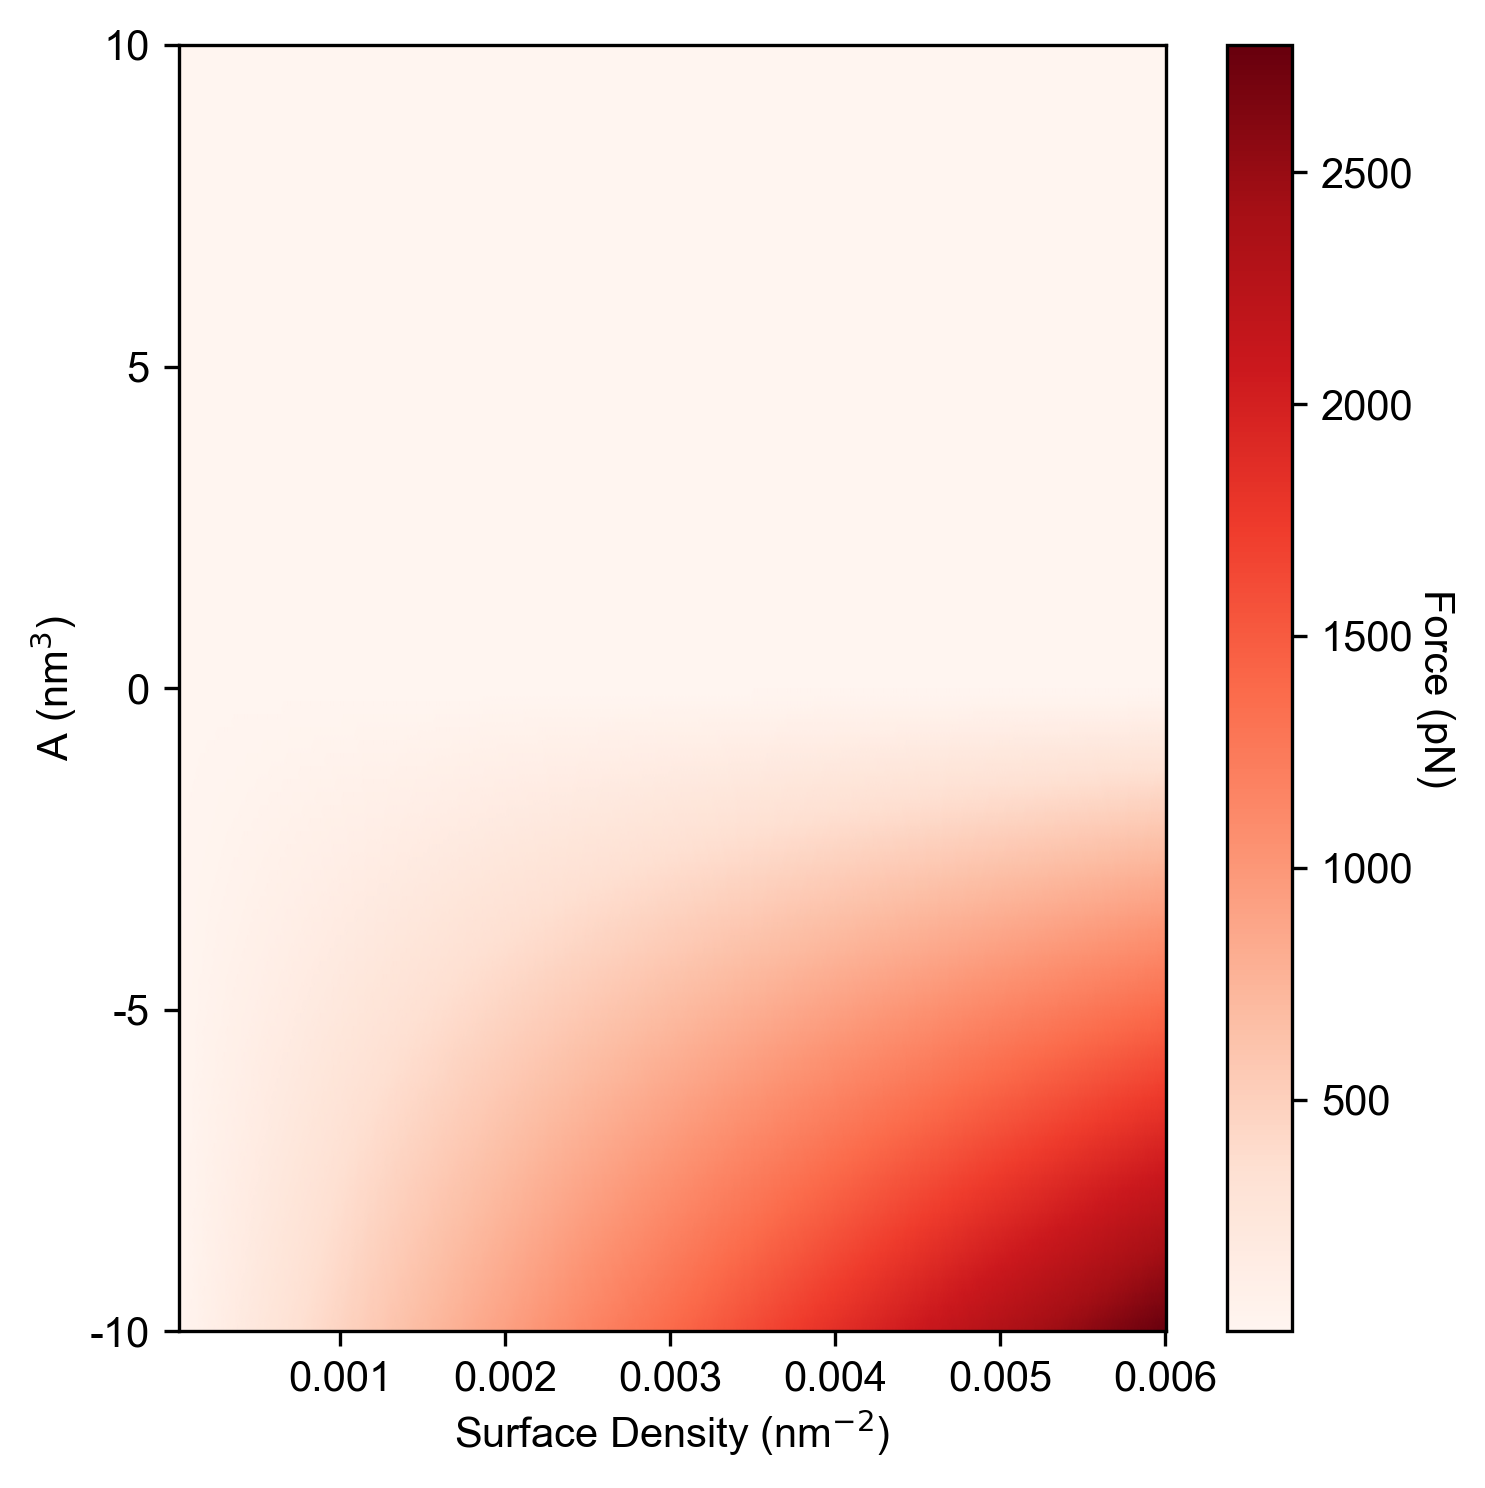

In [8]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

figName = f"phase_map_length"

if plot3D:
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={"projection": "3d"})
else:
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

if plot3D:
    surf = ax.plot_surface(
        cp, A, Force, cmap=cm.viridis, linewidth=0.1, antialiased=True, edgecolor="k"
    )
    # surf = ax.contour3D(cp, A, Z, 100, cmap=cm.RdYlGn)
else:
    surf = ax.pcolormesh(cp, A, Force, cmap=cm.Reds, shading="gouraud", rasterized=True)

ax.set_xlabel(r"Surface Density (nm$^{-2}$)")

ax.set_ylim((As.min(), As.max()))
ax.set_ylabel(r"A (nm$^3$)")
ax.yaxis.set_major_locator(LinearLocator(numticks=5))
ax.yaxis.set_major_formatter("{x:.0f}")


cbar.ax.get_yaxis().labelpad = 10
cbar.ax.set_ylabel("Force (pN)", rotation=270)

if plot3D:
    # ax.set_zlim(-5,5)
    ax.set_zlabel(r"f (pN)")
    ax.zaxis.set_major_formatter("{x:.0f}")
    ax.zaxis.labelpad = 0
else:
    cbar = fig.colorbar(
        surf,
        ax=ax,
    )
    cbar.ax.get_yaxis().labelpad = 10
    cbar.ax.set_ylabel("Force (pN)", rotation=270)

fig.tight_layout()


fig.savefig(curr_fig_path / f"{figName}.png", format="png")
fig.savefig(curr_fig_path / f"{figName}.pdf", format="pdf")

if show_figs:
    plt.show()
fig.clear()
plt.close(fig)
